In [92]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
import imutils
from sklearn.utils import shuffle
from keras.models import Model, optimizers, load_model
from keras.layers import Conv2D, Input, Deconv2D, Add
from sklearn.model_selection import train_test_split
import pickle

In [93]:
def show(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [94]:
def read_pgm(pgmf):
    pgmf.readline()
    (width, height) = [int(i) for i in pgmf.readline().split()]
    depth = int(pgmf.readline())
    assert depth <= 255

    raster = []
    for y in range(height):
        row = []
        for y in range(width):
            row.append(ord(pgmf.read(1)))
        raster.append(row)
    return np.array(raster).astype(np.uint8)

In [100]:
def read_face_dataset(low, high):
    dataset = []
    folder = "orl_faces"
    for i in range(low, high):
        for file in os.listdir(os.path.join(folder, 's' + str(i))):
            filepath = os.path.join(folder, 's' + str(i), file)
            pgm = open(filepath, 'rb')
            image = read_pgm(pgm)
            pgm.close()
            dataset.append(image)
    return dataset

In [101]:
def add_noise(img):
    image = img.copy()
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if np.random.random() < 0.1:
                image[i][j] = 255
    return image

In [98]:
def generate_data(dataset):
    data = []
    labels = []
    for idx, image in enumerate(dataset):
        image = imutils.resize(image, width=46)
        labels += [image, image]
        
        img = cv.GaussianBlur(image, (5, 5), 0)
        data.append(img)
        
        img = cv.GaussianBlur(image, (7, 7), 0)
        data.append(img)
        
    return np.array(data), np.array(labels)

In [190]:
train_dataset = read_face_dataset(1, 36)
x_train, y_train = generate_data(train_dataset)
x_train = x_train.reshape((-1, x_train.shape[1], x_train.shape[2], 1))
y_train = y_train.reshape((-1, y_train.shape[1], y_train.shape[2], 1))
print((x_train.shape, y_train.shape))

((700, 56, 46, 1), (700, 56, 46, 1))


In [191]:
test_dataset = read_face_dataset(36, 41)
x_test, y_test = generate_data(test_dataset)
x_test = x_test.reshape((-1, x_test.shape[1], x_test.shape[2], 1))
y_test = y_test.reshape((-1, y_test.shape[1], y_test.shape[2], 1))
print((x_test.shape, y_test.shape))

((100, 56, 46, 1), (100, 56, 46, 1))


In [196]:
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)
pickle.dump([x_train, x_test, y_train, y_test], open('data.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)
# x_train, x_test, y_train, y_test = pickle.load(open('data.pkl', 'rb'))

In [9]:
input_img = Input(shape=(56, 46, 1))

conv1 = Conv2D(48, (7, 7), activation='relu', padding='same')(input_img)
conv1 = Conv2D(48, (7, 7), activation='relu', padding='same')(conv1)

conv2 = Conv2D(64, (5, 5), activation='relu', padding='same')(conv1)
conv2 = Conv2D(64, (5, 5), activation='relu', padding='same')(conv2)

conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

conv4 = Conv2D(96, (3, 3), activation='relu', padding='same')(conv3)
conv4 = Conv2D(96, (3, 3), activation='relu', padding='same')(conv4)

dconv1 = Deconv2D(96, (3,3), activation='relu', padding='same')(conv4)
dconv1 = Deconv2D(96, (3,3), activation='relu', padding='same')(dconv1)
dconv1 = Add()([dconv1, conv4])

dconv2 = Deconv2D(64, (3,3), activation='relu', padding='same')(dconv1)
dconv2 = Deconv2D(64, (3,3), activation='relu', padding='same')(dconv2)
dconv2 = Add()([dconv2, conv3])

dconv3 = Deconv2D(64, (5,5), activation='relu', padding='same')(dconv2)
dconv3 = Deconv2D(64, (5,5), activation='relu', padding='same')(dconv3)
dconv3 = Add()([dconv3, conv2])

dconv4 = Deconv2D(48, (7,7), activation='relu', padding='same')(dconv3)
dconv4 = Deconv2D(48, (7,7), activation='relu', padding='same')(dconv4)
dconv4 = Add()([dconv4, conv1])

output_img = Conv2D(1, (7, 7), activation='relu', padding='same')(dconv4)

In [10]:
autoencoder = Model(input_img, output_img)
optimizer = optimizers.Adam(lr=0.0002)
autoencoder.compile(optimizer=optimizer, loss='mse')
# autoencoder.summary()

In [11]:
# autoencoder.fit(x_train, y_train,
#                 epochs=15,
#                 batch_size=32,
#                 shuffle=True,
#                 validation_data=(x_test, y_test))

In [12]:
# autoencoder.save('model5.h5')

In [66]:
autoencoder.set_weights(load_model('bestofbest.h5').get_weights())

In [259]:
img = cv.imread('the.jpg', 0)
imgo = imutils.resize(img, width=46)[2:58]
# show(image)
img = cv.GaussianBlur(imgo, (7,7), 0)
# show(image)
img = img.reshape((1,56,46,1))

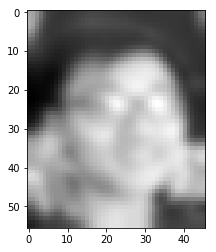

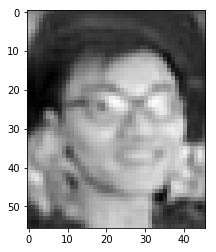

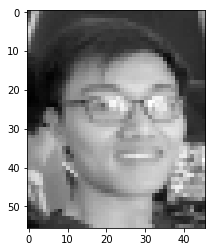

In [260]:
n = np.random.randint(100)
# image = x_test[n:n+1]
image = img
pred = autoencoder.predict(image)
# o_image = y_test[n:n+1]
show(image.reshape((image.shape[1], image.shape[2])))
show(pred.reshape((pred.shape[1], pred.shape[2])))
show(imgo.reshape((imgo.shape[0], imgo.shape[1])))